# Forward model using the Waveform Simulator

*Bart Pelssers, 27-03-2018*

Provides forward model for the ABC project using the Pax Waveform Simulator (Fax).


In [1]:
import numpy as np

In [2]:
np.warnings.filterwarnings('ignore')

In [3]:
from pax.core import Processor

In [4]:
class Model():
    """Implements the forward model for ABC project.
    
       The forward model used here uses the full pax waveformsimulation
       as input and the pax processing for output.
       
       Given a certain x,y position the model will first simulate an
       event using the waveformsimulator. Then reconstruct this event
       with the processor. It will then return the hit pattern of the
       main S2 of the event.
    """

    def __init__(self, config_filename = 'XENON1T_ABC_all_pmts_on.ini'):
        # Setup pax using a custom configuration 'XENON1T_ABC.ini'
        self.pax = Processor(config_paths = [config_filename])
        # Get access to the input plugin WaveformSimulatorInput
        # derived from the WaveformSimulator class
        self.input_plugin = self.pax.get_plugin_by_name('WaveformSimulatorInput')
        # Use DummyOutput, it does not write to any file but
        # stores the event in its last_event variable
        self.output_plugin = self.pax.get_plugin_by_name('DummyOutput')
        
        # Dirty workaround for not using data derived spe gains if all PMTs on
        if config_filename.startswith('XENON1T_ABC_all_pmts_on'):
            gain_sigmas = [0.35 * g for g in self.pax.config['DEFAULT']['gains']]
            self.pax.config['DEFAULT']['gain_sigmas'] = gain_sigmas
            self.pax.config['gain_sigmas'] = gain_sigmas
            self.input_plugin.config['gain_sigmas'] = gain_sigmas
            self.input_plugin.simulator.config['gain_sigmas'] = gain_sigmas
            
    
    def change_defaults(self, z = 0.0, t = 10000,
                        recoil_type = 'NR', s1_photons=50, s2_electrons = 25):
        # Set new default options
        # str() converts are necassary to work with WaveformSimulator
        new_defaults = {'g4_id': -1,
                        'x': 0.0,
                        'y': 0.0,
                        'z': str(z),
                        't': str(t),
                        'recoil_type': recoil_type,
                        's1_photons': str(s1_photons),
                        's2_electrons': str(s2_electrons),
                        }
        self.input_plugin.default_instruction = new_defaults.copy()

    def __call__(self, x, y, batch_size=1, random_state=None):
        """Returns a hitpattern of s2_electrons
           for given x, y interaction position.
        """
        # Set new x,y position
        self.input_plugin.set_instruction_for_next_event(x, y)
        # Run the waveformsimulator and pax processor
        self.pax.run(clean_shutdown=False)
        # Return the top hit pattern of the main S2 of the processed event
        return self.output_plugin.last_event.main_s2.area_per_channel[:127]
    
    def get_latest_pax_position(self):
        # Return the reconstructed positions by pax for the last
        # processed event
        pos_rec = {}
        select_algorithm = ['PosRecNeuralNet', 'PosRecTopPatternFit']
        for rp in self.output_plugin.last_event.main_s2.reconstructed_positions:
            if rp.algorithm in select_algorithm:
                pos_rec[rp.algorithm] = {'x': rp.x,
                                         'y': rp.y}
        return pos_rec        

In [5]:
# Initialize the model
model = Model('XENON1T_ABC.ini')  # or use 'XENON1T_ABC.ini' to have some top PMTs off

### this is because we will vectorize model (for using elfi.Distance) but we need to get the hitpattern as the event changes
model_only_y_obs = Model('XENON1T_ABC.ini')  # or use 'XENON1T_ABC.ini' to have some top PMTs off

You don't have ROOT or root_pandas, root truth file output is disabled


In [6]:
# OPTIONALLY: Set different defaults for z,t,recoil_type,s1_photons_s2_electrons: if, CHANGE ON BOTH
model.change_defaults(s2_electrons = 25)
model_only_y_obs.change_defaults(s2_electrons = 25)

In [7]:
# View the current defaults
model.input_plugin.default_instruction

{'g4_id': -1,
 'recoil_type': 'NR',
 's1_photons': '50',
 's2_electrons': '25',
 't': '10000',
 'x': 0.0,
 'y': 0.0,
 'z': '0.0'}

# Python 3.5 and ELFI

In [8]:
import sys
sys.version

'3.5.5 |Anaconda, Inc.| (default, Mar 12 2018, 23:12:44) \n[GCC 7.2.0]'

In [9]:
import elfi

In [10]:
###Observed dataset
trueCoordMatrix=np.loadtxt('truepos')
print("True Coordinates")

###pick an event j
j=0
print(trueCoordMatrix[j])

trueCoord=trueCoordMatrix[j]
TrueModel=model_only_y_obs(trueCoord[0], trueCoord[1])

y_obs=TrueModel
print(y_obs)

True Coordinates
[  2.62643434 -17.96082368]
[ 0.          0.          0.          0.          0.          0.57011144
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.20921854
  0.          0.6909395   0.          3.32031055  0.          0.
  0.          3.94893962  0.          0.          0.          0.
  0.63784695  0.          0.          0.          0.          1.80042333
  0.          2.12833207  0.          0.          1.20921385  0.
  0.6610664   0.          0.          0.93422962  3.08254724  1.14286093
  2.80326444  2.29963951  2.10416673  0.          0.          0.
  0.73595907  1.37852621  1.55656439  0.          2.48762493  0.
  0.          0.          0.          0.          0.          0.
  0.          0.96182584  1.41850538  0.          0.          0.
  0.63802253  0.          0.          0.          2.52819665  1.32843248
  4.78545458  0.          7.47737948  3.74348869  3.92910366  2.830586

In [11]:
pos_dict = model_only_y_obs.get_latest_pax_position()
pos_dict

{'PosRecNeuralNet': {'x': 3.035267538429507, 'y': -18.572654273254024},
 'PosRecTopPatternFit': {'x': 2.618421052631575, 'y': -18.578320802005013}}

In [12]:
from pax.configuration import load_configuration

In [13]:
#Definition of the fuction for retrieving the NAIVE coordinates

class PriorPosition():
    """Implements the calculation of the mean of a prior
       given a pattern (either from data or from the forward model)
    """
    
    def __init__(self):
        # Get some settings from the XENON1T detector configuration
        config = load_configuration('XENON1T')
        
        # PMT positions
        pmt_config = config['DEFAULT']['pmts']
        
        # List of dicts {'x': , 'y'}, which the position
        self.positions = [pmt['position'] for pmt in pmt_config][:127]

    def __call__(self, pattern):
        # The id of the PMT that sees most light
        max_pmt = np.argmax(pattern)
        
        # The position of that PMT
        pos = self.positions[max_pmt]
        
        return pos['x'], pos['y']


In [14]:
prior_mean = PriorPosition()
naiveCoord=prior_mean(y_obs)

print(naiveCoord)

(4.115222817130077, -15.358220637996187)


In [15]:
###Prior distributions: REMEMBER TO ADD THE CONSTRAINT

#xProp=elfi.Prior('norm',trueCoord[0],10)
#yProp=elfi.Prior('norm',trueCoord[1],10)
xProp=elfi.Prior('norm',naiveCoord[0],10)
yProp=elfi.Prior('norm',naiveCoord[1],10)

#print(elfi.Simulator.generate(xProp), elfi.Simulator.generate(yProp))

In [16]:
#we need to vectorize model, because of elfi.Distance. Do it only once
model=elfi.tools.vectorize(model)

In [17]:
###Simulated Dataset
Y = elfi.Simulator(model, xProp, yProp, observed=y_obs)
#Y = elfi.Simulator(model, xProp, yProp)
print(elfi.Simulator.generate(Y))

[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.79471247   3.63415017   0.           1.59533533   0.
    0.           0.           0.           0.65078553   0.83570175
    1.06905865   0.           0.           0.           0.
    1.44154885   0.           0.           0.           0.84569944
    0.           0.           0.           0.           0.
    0.           0.           0.           1.13973088   0.
    0.           0.           1.44230889   1.8034418    4.44294481
    2.48772082   1.70836466   2.18518493   0.           0.
    1.23921435   1.39656642   0.           3.40533266   1.28765313
    0.77397752   0.18760026   0.           0.           0.
    0.           0.           0.           1.02500182   0.
    0.           0.           0.           0.           1.15574455
    1.26064135   0.           1.66838737   0.           0.
    0.           3.53960016   4.10792534   6.16240339   0.
    4.74675375  

In [18]:
d = elfi.Distance('euclidean', Y)

print(elfi.Simulator.generate(d))

[68.47071016]


In [19]:
log_d = elfi.Operation(np.log, d)

print(elfi.Simulator.generate(log_d))

[5.03690563]


In [20]:
bolfi = elfi.BOLFI(log_d, batch_size=1, initial_evidence=50, update_interval=10, 
                   bounds={'xProp':(-30, 30), 'yProp':(-30, 30)}, acq_noise_var=[0.1, 0.1])

In [21]:
%time post = bolfi.fit(n_evidence=200)

CPU times: user 6min 38s, sys: 6.35 s, total: 6min 45s
Wall time: 2min 3s


In [22]:
bolfi.target_model


Name : GP regression
Objective : -26.278304848975232
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |    priors   
  sum.rbf.variance         |   0.06123274060294675  |      +ve      |  Ga(1.5, 1) 
  sum.rbf.lengthscale      |     4.906967747026809  |      +ve      |   Ga(20, 1) 
  sum.bias.variance        |    3.1370977619666722  |      +ve      |  Ga(0.38, 1)
  Gaussian_noise.variance  |  0.019969939424438362  |      +ve      |             

<Figure size 432x288 with 0 Axes>

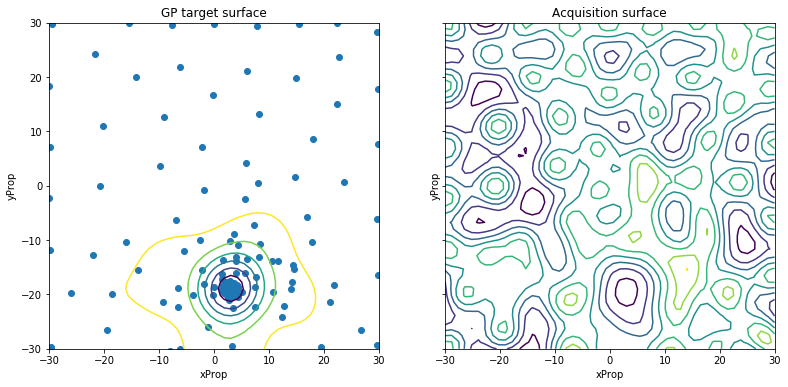

In [23]:
bolfi.plot_state();

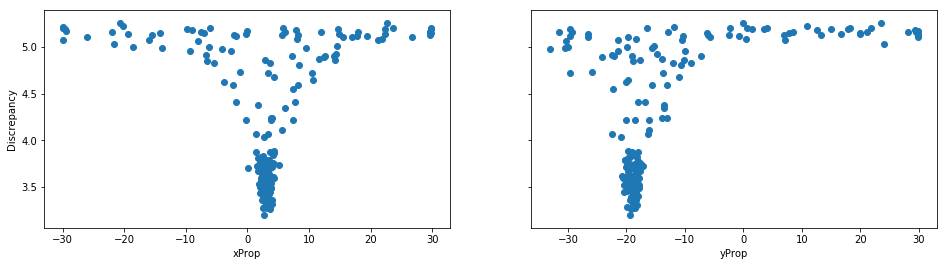

In [24]:
bolfi.plot_discrepancy();

In [25]:
post2 = bolfi.extract_posterior(-1.)

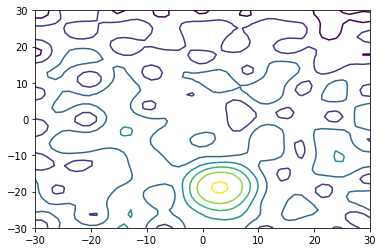

In [26]:
post.plot(logpdf=True)

In [27]:
%time result_BOLFI = bolfi.sample(1000, info_freq=1000)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
xProp 2780.1503993411006 0.9996526809465638
yProp 2535.639848239304 1.0014612180160802
CPU times: user 1min 55s, sys: 548 ms, total: 1min 55s
Wall time: 57.4 s


In [28]:
result_BOLFI

Method: BOLFI
Number of samples: 2000
Number of simulations: 200
Threshold: 3.54
Sample means: xProp: 3.02, yProp: -18.9

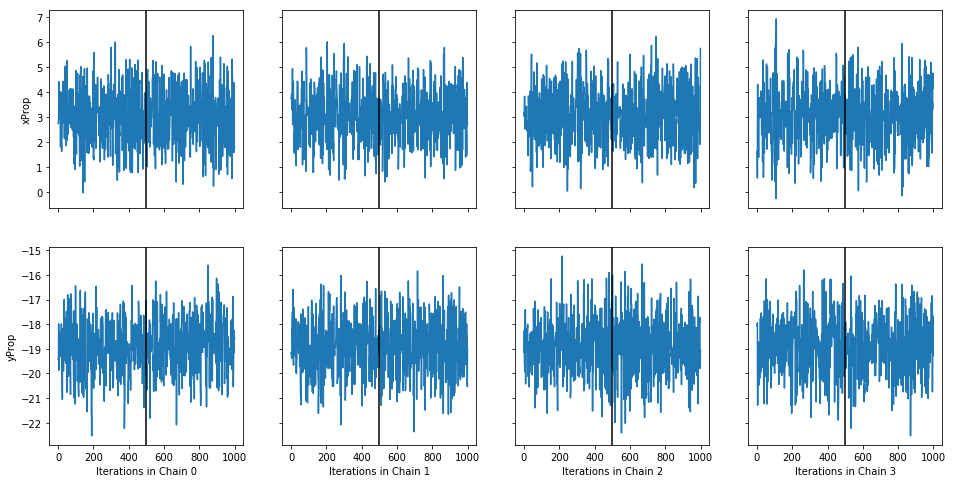

In [29]:
result_BOLFI.plot_traces();

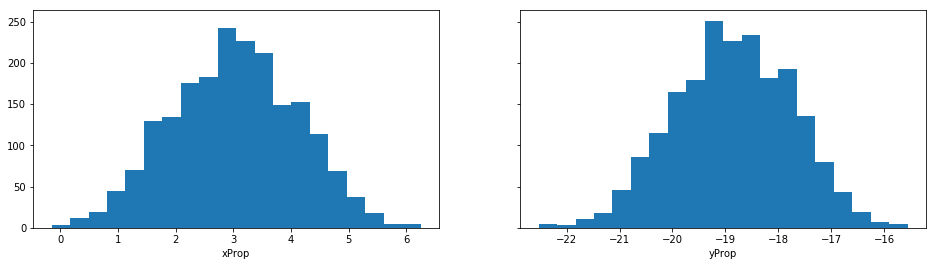

In [30]:
result_BOLFI.plot_marginals();

In [31]:
###Posterior weighted means
result_BOLFI.sample_means

OrderedDict([('xProp', 3.023448188968341), ('yProp', -18.86007918807132)])

In [32]:
print("True Coordinates")
print(trueCoord)
print("Reconstructed Coordinates NN and TPF")
print(pos_dict)
print("Reconstructed Coordinates BOLFI: posterior weighted means")
print(result_BOLFI.sample_means_array)

True Coordinates
[  2.62643434 -17.96082368]
Reconstructed Coordinates NN and TPF
{'PosRecTopPatternFit': {'y': -18.578320802005013, 'x': 2.618421052631575}, 'PosRecNeuralNet': {'y': -18.572654273254024, 'x': 3.035267538429507}}
Reconstructed Coordinates BOLFI: posterior weighted means
[  3.02344819 -18.86007919]


In [ ]:
#Other objects callable from BOLFI object
#result_BOLFI.plot_pairs();
#result_BOLFI.n_samples
#result_BOLFI.dim
#result_BOLFI.samples_array
#result_BOLFI.summary